In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# Load dataset
X_train = pd.read_csv(os.path.join(os.getcwd(), "data", "X_train.csv"))
X_test = pd.read_csv(os.path.join(os.getcwd(), "data", "X_test.csv"))
y_train = pd.read_csv(os.path.join(os.getcwd(), "data", "y_train.csv"))
y_test = pd.read_csv(os.path.join(os.getcwd(), "data", "y_test.csv"))

# Labelling binary features
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous","last_contact_day"]
categorical_features = [col for col in X_train.columns if col not in numerical_features]
categorical_features_index = [list(X_train.columns).index(col) for col in categorical_features]
binary_features = ["default","housing","loan"]
not_binary_categorical = [col for col in categorical_features if col not in binary_features]

le = LabelEncoder()
for c in binary_features:
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])


In [ ]:
# Oversampling
smote_nc = SMOTENC(categorical_features=categorical_features_index, random_state=0, sampling_strategy=0.40)
X_train_os, y_train_os = smote_nc.fit_resample(X_train, y_train)

# Check imbalance in taget variable
print(y_train.value_counts() / len(y_train))

print(y_train_os.value_counts() / len(y_train_os))

# Check train size
print(X_train_os.shape)

In [ ]:
# One hot encoding
enc = OneHotEncoder()
encoded_train = pd.DataFrame(enc.fit_transform(X_train_os[not_binary_categorical]).toarray(), columns=enc.get_feature_names_out())
encoded_test = pd.DataFrame(enc.transform(X_test[not_binary_categorical]).toarray(), columns=enc.get_feature_names_out())

X_train_enc = pd.concat([X_train_os[numerical_features],X_train_os[binary_features],encoded_train], axis=1)
X_test_enc = pd.concat([X_test[numerical_features],X_test[binary_features], encoded_test], axis=1)

In [ ]:
# Model
model = RandomForestClassifier(n_estimators=1000)

# Fit the classifier
model.fit(X_train_enc, y_train_os.values.ravel())

# Make predictions
predictions = model.predict(X_test_enc)


Accuracy: 0.92 - Precision: 0.43 - Recall: 0.46 - F1 Score: 0.44


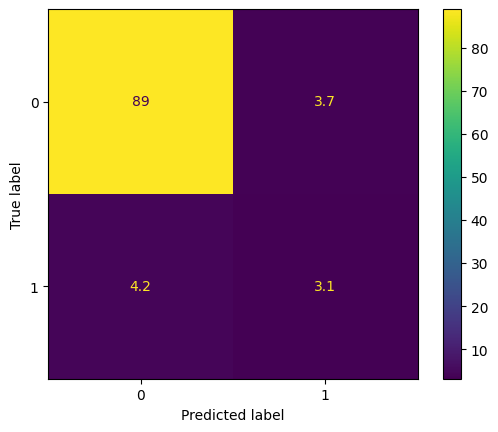

In [12]:

# Calculate metrics
accuracy = accuracy_score(predictions, y_test.values.ravel())
precision = precision_score(predictions, y_test.values.ravel())
recall = recall_score(predictions, y_test.values.ravel())
f1score = f1_score(predictions, y_test.values.ravel())

cm = 100 * confusion_matrix(y_test.values.ravel(), predictions, labels=model.classes_) / len(y_test.values.ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

print(f"Accuracy: {accuracy:.2f} - Precision: {precision:.2f} - Recall: {recall:.2f} - F1 Score: {f1score:.2f}")
disp.plot()
plt.show()

# Plot 3 most important features and 3 less important
importances = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)
importances_to_plot = pd.concat([importances[:3],importances[-3:]])
imp_df = pd.DataFrame(importances_to_plot).reset_index()
imp_df = pd.melt(imp_df, id_vars=['index'], value_vars=imp_df.columns[1:])
fig = px.bar(imp_df, x='index', y='value', width=800, height=600)
fig.update_traces(textposition='outside')
fig.data[-1].text = np.round(imp_df['value'],3)
fig.show()